# Feature Engineering



## Objectives

*   Engineer features for Regression model


## Inputs

* inputs/datasets/cleaned/test_df_cleaned.pkl
* inputs/datasets/cleaned/train_df_cleaned.pkl

## Outputs

* generate a list with variables to engineer

## Conclusions

* Feature Engineering Transformers
* 
* 

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir


'/workspace/Film_Hit_prediction'

---

# Load Cleaned Data

Train Set

In [4]:
import os
import pandas as pd

# Correct path relative to the current directory
Train_set_path = "/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/train_df_cleaned.pkl"

try:
    TrainSet = pd.read_pickle(Train_set_path)
    print(TrainSet.head(3))
    print("Shape of the dataframe:", TrainSet.shape)
except FileNotFoundError:
    print(f"File not found at path: {Train_set_path}")

          budget     revenue  runtime  language_encoded  popularity  Action  \
4688         0.0         0.0     87.0               7.0   31.339015     0.0   
2951  11000000.0  32935319.0    105.0               7.0   36.319205     0.0   
4071   2000000.0  78898765.0    115.0               7.0   41.298723     1.0   

      Adventure  Animation  Comedy  Crime  ...  cast_Woody Harrelson  \
4688        0.0        0.0     0.0    0.0  ...                   0.0   
2951        0.0        0.0     0.0    0.0  ...                   0.0   
4071        1.0        0.0     0.0    0.0  ...                   0.0   

      cast_Xander Berkeley  cast_Yasiin Bey  cast_Yul Vazquez  cast_Zac Efron  \
4688                   0.0              0.0               0.0             0.0   
2951                   0.0              0.0               0.0             0.0   
4071                   0.0              0.0               0.0             0.0   

      cast_Zach Galifianakis  cast_Zeljko Ivanek  cast_Zoe Saldana  \

Test Set

In [5]:
import os
import pandas as pd

# Correct path relative to the current directory
Test_set_path = "/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/test_df_cleaned.pkl"

try:
    TestSet = pd.read_pickle(Test_set_path)
    print(TestSet.head(3))
    print("Shape of the dataframe:", TestSet.shape)
except FileNotFoundError:
    print(f"File not found at path: {Test_set_path}")

          budget     revenue  runtime  language_encoded  popularity  Action  \
596   70000000.0  33561137.0     97.0               7.0   13.267631     1.0   
3372         7.0         5.0     90.0               7.0    4.857028     1.0   
2702  14000000.0   5108820.0     90.0               7.0    5.833687     0.0   

      Adventure  Animation  Comedy  Crime  ...  cast_Woody Harrelson  \
596         1.0        0.0     1.0    0.0  ...                   0.0   
3372        0.0        0.0     0.0    1.0  ...                   0.0   
2702        0.0        0.0     0.0    0.0  ...                   0.0   

      cast_Xander Berkeley  cast_Yasiin Bey  cast_Yul Vazquez  cast_Zac Efron  \
596                    0.0              0.0               0.0             0.0   
3372                   0.0              0.0               0.0             0.0   
2702                   0.0              0.0               0.0             0.0   

      cast_Zach Galifianakis  cast_Zeljko Ivanek  cast_Zoe Saldana  \

# Data Exploration

Evaluate potential transformations to be made


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6a2d281820>>
Traceback (most recent call last):
  File "/home/gitpod/.pyenv/versions/3.8.18/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

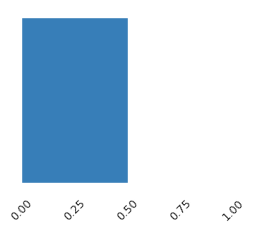

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

# Correlation and PPS Analysis

* We don’t expect changes compared to the data cleaning notebook 

# Feature Engineering

## Custom function

Function for top actors

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

def top_revenue_actors(TrainSet, TestSet, n_actors=100):

    # Create copies of input data to avoid modifications
    train_copy = TrainSet.copy()
    test_copy = TestSet.copy()
    
    #Find actors most correlated with high revenue
    cast_cols = [col for col in TrainSet.columns if col.startswith('cast_')]

    # Calculate multiple metrics for each actor
    actor_metrics = {}
    for col in cast_cols:
        actor_name = col.replace('cast_', '')
        movies_count = TrainSet[col].sum()
        
        if movies_count >= 5:  
            movies_with_actor = TrainSet[TrainSet[col] == 1]
            
            metrics = {
                'movies_count': movies_count,
                'total_revenue': movies_with_actor['revenue'].sum(),
                'avg_revenue': movies_with_actor['revenue'].mean(),
                'revenue_consistency': movies_with_actor['revenue'].std(),
                'hit_rate': (movies_with_actor['revenue'] > movies_with_actor['revenue'].mean()).mean(),
                'avg_popularity': movies_with_actor['popularity'].mean(),
                'popularity_consistency': movies_with_actor['popularity'].std(),
                'revenue_popularity_correlation': movies_with_actor[['revenue', 'popularity']].corr().iloc[0,1]
            }
            
            actor_metrics[actor_name] = metrics
    
    # Sort actors by different metrics and print insights
    print("\nTop actors by total revenue:")
    top_by_total = sorted(actor_metrics.items(), key=lambda x: x[1]['total_revenue'], reverse=True)[:20]
    for actor, metrics in top_by_total:
        print(f"- {actor}: Total revenue ${metrics['total_revenue']:,.2f} ({metrics['movies_count']} movies)")
        
    print("\nTop actors by average popularity (minimum 10 movies):")
    top_by_popularity = [(actor, metrics) for actor, metrics in actor_metrics.items() 
                        if metrics['movies_count'] >= 10]
    top_by_popularity = sorted(top_by_popularity, key=lambda x: x[1]['avg_popularity'], reverse=True)[:20]
    for actor, metrics in top_by_popularity:
        print(f"- {actor}: Avg popularity {metrics['avg_popularity']:.2f} ({metrics['movies_count']} movies)")
        
    print("\nActors with strongest revenue-popularity correlation:")
    top_by_correlation = [(actor, metrics) for actor, metrics in actor_metrics.items() 
                         if metrics['movies_count'] >= 10]
    top_by_correlation = sorted(top_by_correlation, key=lambda x: abs(x[1]['revenue_popularity_correlation']), reverse=True)[:20]
    for actor, metrics in top_by_correlation:
        print(f"- {actor}: Correlation {metrics['revenue_popularity_correlation']:.3f}")

    # Enhanced composite score including popularity metrics
    for actor in actor_metrics:
        metrics = actor_metrics[actor]
        # Normalize each metric between 0 and 1
        revenue_norm = metrics['total_revenue'] / max(m['total_revenue'] for m in actor_metrics.values())
        avg_norm = metrics['avg_revenue'] / max(m['avg_revenue'] for m in actor_metrics.values())
        consistency_norm = 1 - (metrics['revenue_consistency'] / max(m['revenue_consistency'] for m in actor_metrics.values()))
        popularity_norm = metrics['avg_popularity'] / max(m['avg_popularity'] for m in actor_metrics.values())
        correlation_norm = abs(metrics['revenue_popularity_correlation'])
        
        # Composite score with popularity factors
        metrics['composite_score'] = (
            0.3 * revenue_norm +           # Total revenue importance
            0.2 * avg_norm +               # Average revenue importance
            0.2 * consistency_norm +       # Revenue consistency importance
            0.2 * popularity_norm +        # Popularity importance
            0.1 * correlation_norm         # Revenue-popularity correlation importance
        )

    # Get top actors based on composite score
    top_actors = sorted(actor_metrics.items(), key=lambda x: x[1]['composite_score'], reverse=True)[:n_actors]
    
    # Convert to column names for processing
    top_actor_cols = [f"cast_{actor}" for actor, _ in top_actors]

    # Process train and test data
    processed_dfs = []
    for df in [train_copy, test_copy]:
        processed = df.copy()
        
        # Add top actor columns
        for actor_col in top_actor_cols:
            if actor_col in df.columns:
                processed[actor_col] = df[actor_col]
                # Add popularity weighted presence
                actor_metrics_dict = {name: metrics for name, metrics in actor_metrics.items()}
                actor_name = actor_col.replace('cast_', '')
                if actor_name in actor_metrics_dict:
                    processed[f"{actor_col}_pop_weight"] = (
                        df[actor_col] * actor_metrics_dict[actor_name]['avg_popularity']
                    )
            else:
                processed[actor_col] = 0
                processed[f"{actor_col}_pop_weight"] = 0
        
        # Calculate other_actor_count and their average popularity
        all_cast_cols = [col for col in df.columns if col.startswith('cast_')]
        other_cast_cols = [col for col in all_cast_cols if col not in top_actor_cols]
        processed['other_actor_count'] = df[other_cast_cols].sum(axis=1)
        
        # Drop original cast columns
        cols_to_keep = [col for col in processed.columns 
                       if not col.startswith('cast_') or col in top_actor_cols 
                       or col.endswith('_pop_weight')]
        cols_to_keep.append('other_actor_count')
        processed = processed[cols_to_keep]
        
        processed_dfs.append(processed)
    
    # Save top actors and their metrics for future use
    with open('top_revenue_actors.pkl', 'wb') as f:
        pickle.dump({'columns': top_actor_cols, 'metrics': actor_metrics}, f)
    
    return processed_dfs[0], processed_dfs[1]

In [9]:
TrainSet_processed, TestSet_processed = top_revenue_actors(TrainSet, TestSet, n_actors=100)

# See what the processed data looks like
print("\nProcessed train shape:", TrainSet_processed.shape)
print("Processed test shape:", TestSet_processed.shape)


Top actors by total revenue:
- Stan Lee: Total revenue $13,028,389,897.00 (19.0 movies)
- John Ratzenberger: Total revenue $11,038,044,745.00 (22.0 movies)
- Samuel L. Jackson: Total revenue $10,669,812,264.00 (52.0 movies)
- Frank Welker: Total revenue $9,236,754,276.00 (27.0 movies)
- Hugo Weaving: Total revenue $9,156,461,213.00 (18.0 movies)
- Tom Hanks: Total revenue $8,659,594,989.00 (29.0 movies)
- Jess Harnell: Total revenue $8,650,836,565.00 (14.0 movies)
- Cate Blanchett: Total revenue $8,131,705,275.00 (24.0 movies)
- Andy Serkis: Total revenue $7,810,516,395.00 (19.0 movies)
- Morgan Freeman: Total revenue $7,568,156,106.00 (39.0 movies)
- Tom Cruise: Total revenue $7,430,856,641.00 (28.0 movies)
- Alan Tudyk: Total revenue $7,321,351,720.00 (22.0 movies)
- Ian McKellen: Total revenue $7,219,005,112.00 (14.0 movies)
- Stellan Skarsgård: Total revenue $7,148,281,476.00 (19.0 movies)
- Will Smith: Total revenue $6,953,647,823.00 (20.0 movies)
- Christopher Lee: Total revenue

/tmp/ipykernel_3907/1063496742.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[f"{actor_col}_pop_weight"] = (
/tmp/ipykernel_3907/1063496742.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[f"{actor_col}_pop_weight"] = (
/tmp/ipykernel_3907/1063496742.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,


Processed train shape: (3842, 1999)
Processed test shape: (961, 1999)


Function for top directors

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

def top_revenue_directors(TrainSet, TestSet, n_directors=100):
    # Create copies of input data to avoid modifications
    train_copy = TrainSet.copy()
    test_copy = TestSet.copy()

    # Find top revenue-generating directors
    director_cols = [col for col in TrainSet.columns if col.startswith('crew_Director_')]
    print(f"Number of director columns found: {len(director_cols)}")
    print("First few director columns:", director_cols[:5])
    
    # Calculate multiple metrics for each director
    director_metrics = {}
    for col in director_cols:
        director_name = col.replace('crew_Director_', '')
        movies_count = TrainSet[col].sum()
        
        if movies_count >= 5:
            movies_with_director = TrainSet[TrainSet[col] == 1]
            
            metrics = {
                'movies_count': movies_count,
                'total_revenue': movies_with_director['revenue'].sum(),
                'avg_revenue': movies_with_director['revenue'].mean(),
                'revenue_consistency': movies_with_director['revenue'].std(),
                'hit_rate': (movies_with_director['revenue'] > movies_with_director['revenue'].mean()).mean(),
                'avg_popularity': movies_with_director['popularity'].mean(),
                'popularity_consistency': movies_with_director['popularity'].std(),
                'revenue_popularity_correlation': movies_with_director[['revenue', 'popularity']].corr().iloc[0,1]
            }
            
            director_metrics[director_name] = metrics
    
    # Sort directors by different metrics and print insights
    print("\nTop directors by total revenue:")
    top_by_total = sorted(director_metrics.items(), key=lambda x: x[1]['total_revenue'], reverse=True)[:20]
    for director, metrics in top_by_total:
        print(f"- {director}: Total revenue ${metrics['total_revenue']:,.2f} ({metrics['movies_count']} movies)")
        
    print("\nTop directors by average popularity (minimum 10 movies):")
    top_by_popularity = [(director, metrics) for director, metrics in director_metrics.items() 
                        if metrics['movies_count'] >= 10]
    top_by_popularity = sorted(top_by_popularity, key=lambda x: x[1]['avg_popularity'], reverse=True)[:20]
    for director, metrics in top_by_popularity:
        print(f"- {director}: Avg popularity {metrics['avg_popularity']:.2f} ({metrics['movies_count']} movies)")
        
    print("\nDirectors with strongest revenue-popularity correlation:")
    top_by_correlation = [(director, metrics) for director, metrics in director_metrics.items() 
                         if metrics['movies_count'] >= 10]
    top_by_correlation = sorted(top_by_correlation, key=lambda x: abs(x[1]['revenue_popularity_correlation']), reverse=True)[:20]
    for director, metrics in top_by_correlation:
        print(f"- {director}: Correlation {metrics['revenue_popularity_correlation']:.3f}")

    # Enhanced composite score including popularity metrics
    for director in director_metrics:
        metrics = director_metrics[director]
        # Normalize each metric between 0 and 1
        revenue_norm = metrics['total_revenue'] / max(m['total_revenue'] for m in director_metrics.values())
        avg_norm = metrics['avg_revenue'] / max(m['avg_revenue'] for m in director_metrics.values())
        consistency_norm = 1 - (metrics['revenue_consistency'] / max(m['revenue_consistency'] for m in director_metrics.values()))
        popularity_norm = metrics['avg_popularity'] / max(m['avg_popularity'] for m in director_metrics.values())
        correlation_norm = abs(metrics['revenue_popularity_correlation'])
        
        # Composite score with popularity factors
        metrics['composite_score'] = (
            0.3 * revenue_norm +           # Total revenue importance
            0.2 * avg_norm +               # Average revenue importance
            0.2 * consistency_norm +       # Revenue consistency importance
            0.2 * popularity_norm +        # Popularity importance
            0.1 * correlation_norm         # Revenue-popularity correlation importance
        )

    # Get top directors based on composite score
    top_directors = sorted(director_metrics.items(), key=lambda x: x[1]['composite_score'], reverse=True)[:n_directors]
    
    # Convert to column names for processing
    top_director_cols = [f"director_{director}" for director, _ in top_directors]

    # Process train and test data
    processed_dfs = []
    for df in [train_copy, test_copy]:
        processed = df.copy()
        
        # Add top director columns
        for director_col in top_director_cols:
            if director_col in df.columns:
                processed[director_col] = df[director_col]
                # Add popularity weighted presence
                director_metrics_dict = {name: metrics for name, metrics in director_metrics.items()}
                director_name = director_col.replace('director_', '')
                if director_name in director_metrics_dict:
                    processed[f"{director_col}_pop_weight"] = (
                        df[director_col] * director_metrics_dict[director_name]['avg_popularity']
                    )
            else:
                processed[director_col] = 0
                processed[f"{director_col}_pop_weight"] = 0

        
        # Calculate other_director_count and their average popularity
        all_director_cols = [col for col in df.columns if col.startswith('director_')]
        other_director_cols = [col for col in all_director_cols if col not in top_director_cols]
        processed['other_director_count'] = df[other_director_cols].sum(axis=1)
        
        # Drop original director columns
        cols_to_keep = [col for col in processed.columns 
                       if not col.startswith('director_') or col in top_director_cols 
                       or col.endswith('_pop_weight')]
        cols_to_keep.append('other_director_count')
        processed = processed[cols_to_keep]
        
        processed_dfs.append(processed)
    
    # Save top directors and their metrics for future use
    with open('top_revenue_directors.pkl', 'wb') as f:
        pickle.dump({'columns': top_director_cols, 'metrics': director_metrics}, f)
    
    return processed_dfs[0], processed_dfs[1]

In [11]:
print("\nStarting director feature engineering...")
TrainSet_processed, TestSet_processed = top_revenue_directors(TrainSet, TestSet, n_directors=100)

# See what the processed data looks like
print("\nFeature Engineering Summary:")
print("-" * 30)
print("Top directors analyzed by:")
print("- Total revenue")
print("- Average popularity")
print("- Revenue-popularity correlation")
print("\nDataset Shapes:")
print(f"Processed train shape: {TrainSet_processed.shape}")
print(f"Processed test shape: {TestSet_processed.shape}")




Starting director feature engineering...
Number of director columns found: 537
First few director columns: ['crew_Director_Aaron Seltzer', 'crew_Director_Adam McKay', 'crew_Director_Adam Shankman', 'crew_Director_Adrian Lyne', 'crew_Director_Alan Parker']

Top directors by total revenue:
- Steven Spielberg: Total revenue $7,541,574,026.00 (20.0 movies)
- Peter Jackson: Total revenue $5,542,623,032.00 (8.0 movies)
- James Cameron: Total revenue $5,285,198,239.00 (5.0 movies)
- Michael Bay: Total revenue $4,569,015,292.00 (10.0 movies)
- Chris Columbus: Total revenue $3,725,631,503.00 (10.0 movies)
- Robert Zemeckis: Total revenue $3,394,886,126.00 (12.0 movies)
- Tim Burton: Total revenue $3,273,246,942.00 (12.0 movies)
- Sam Raimi: Total revenue $2,998,496,110.00 (7.0 movies)
- Roland Emmerich: Total revenue $2,956,821,040.00 (8.0 movies)
- Carlos Saldanha: Total revenue $2,793,148,786.00 (5.0 movies)
- Ron Howard: Total revenue $2,532,249,144.00 (12.0 movies)
- Zack Snyder: Total rev

/tmp/ipykernel_3907/4068111553.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[f"{director_col}_pop_weight"] = 0
/tmp/ipykernel_3907/4068111553.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[director_col] = 0
/tmp/ipykernel_3907/4068111553.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n


Feature Engineering Summary:
------------------------------
Top directors analyzed by:
- Total revenue
- Average popularity
- Revenue-popularity correlation

Dataset Shapes:
Processed train shape: (3842, 3330)
Processed test shape: (961, 3330)


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle


def top_revenue_writers(TrainSet, TestSet, n_writers=100):
    # Create copies of input data to avoid modifications
    train_copy = TrainSet.copy()
    test_copy = TestSet.copy()

    # Find top revenue-generating writers
    writer_cols = [col for col in TrainSet.columns if col.startswith('crew_Writer_')]
    
    # Calculate multiple metrics for each writer
    writer_metrics = {}
    for col in writer_cols:
        writer_name = col.replace('crew_Writer_', '')
        movies_count = TrainSet[col].sum()
        
        if movies_count >= 5:
            movies_with_writer = TrainSet[TrainSet[col] == 1]
            
            metrics = {
                'movies_count': movies_count,
                'total_revenue': movies_with_writer['revenue'].sum(),
                'avg_revenue': movies_with_writer['revenue'].mean(),
                'revenue_consistency': movies_with_writer['revenue'].std(),
                'hit_rate': (movies_with_writer['revenue'] > movies_with_writer['revenue'].mean()).mean(),
                'avg_popularity': movies_with_writer['popularity'].mean(),
                'popularity_consistency': movies_with_writer['popularity'].std(),
                'revenue_popularity_correlation': movies_with_writer[['revenue', 'popularity']].corr().iloc[0,1]
            }
            
            writer_metrics[writer_name] = metrics
    
    # Sort writers by different metrics and print insights
    print("\nTop writers by total revenue:")
    top_by_total = sorted(writer_metrics.items(), key=lambda x: x[1]['total_revenue'], reverse=True)[:20]
    for writer, metrics in top_by_total:
        print(f"- {writer}: Total revenue ${metrics['total_revenue']:,.2f} ({metrics['movies_count']} movies)")
        
    print("\nTop writers by average popularity (minimum 5 movies):")
    top_by_popularity = [(writer, metrics) for writer, metrics in writer_metrics.items() 
                        if metrics['movies_count'] >= 5]
    top_by_popularity = sorted(top_by_popularity, key=lambda x: x[1]['avg_popularity'], reverse=True)[:20]
    for writer, metrics in top_by_popularity:
        print(f"- {writer}: Avg popularity {metrics['avg_popularity']:.2f} ({metrics['movies_count']} movies)")
        
    print("\nWriters with strongest revenue-popularity correlation:")
    top_by_correlation = [(writer, metrics) for writer, metrics in writer_metrics.items() 
                         if metrics['movies_count'] >= 5]
    top_by_correlation = sorted(top_by_correlation, key=lambda x: abs(x[1]['revenue_popularity_correlation']), reverse=True)[:20]
    for writer, metrics in top_by_correlation:
        print(f"- {writer}: Correlation {metrics['revenue_popularity_correlation']:.3f}")

    # Enhanced composite score including popularity metrics
    for writer in writer_metrics:
        metrics = writer_metrics[writer]
        # Normalize each metric between 0 and 1
        revenue_norm = metrics['total_revenue'] / max(m['total_revenue'] for m in writer_metrics.values())
        avg_norm = metrics['avg_revenue'] / max(m['avg_revenue'] for m in writer_metrics.values())
        consistency_norm = 1 - (metrics['revenue_consistency'] / max(m['revenue_consistency'] for m in writer_metrics.values()))
        popularity_norm = metrics['avg_popularity'] / max(m['avg_popularity'] for m in writer_metrics.values())
        correlation_norm = abs(metrics['revenue_popularity_correlation'])
        
        # Composite score with popularity factors
        metrics['composite_score'] = (
            0.3 * revenue_norm +           # Total revenue importance
            0.2 * avg_norm +               # Average revenue importance
            0.2 * consistency_norm +       # Revenue consistency importance
            0.2 * popularity_norm +        # Popularity importance
            0.1 * correlation_norm         # Revenue-popularity correlation importance
        )

    # Get top writers based on composite score
    top_writers = sorted(writer_metrics.items(), key=lambda x: x[1]['composite_score'], reverse=True)[:n_writers]
    
    # Convert to column names for processing
    top_writer_cols = [f"crew_Writer_{writer}" for writer, _ in top_writers]

    # Process train and test data
    processed_dfs = []
    for df in [train_copy, test_copy]:
        processed = df.copy()
        
        # Add top writer columns
        for writer_col in top_writer_cols:
            if writer_col in df.columns:
                processed[writer_col] = df[writer_col]
                # Add popularity weighted presence
                writer_metrics_dict = {name: metrics for name, metrics in writer_metrics.items()}
                writer_name = writer_col.replace('crew_Writer_', '')
                if writer_name in writer_metrics_dict:
                    processed[f"{writer_col}_pop_weight"] = (
                        df[writer_col] * writer_metrics_dict[writer_name]['avg_popularity']
                    )
            else:
                processed[writer_col] = 0
                processed[f"{writer_col}_pop_weight"] = 0
        
        # Calculate other_writer_count
        all_writer_cols = [col for col in df.columns if col.startswith('crew_Writer_')]
        other_writer_cols = [col for col in all_writer_cols if col not in top_writer_cols]
        processed['other_writer_count'] = df[other_writer_cols].sum(axis=1)
        
        # Drop original writer columns
        cols_to_keep = [col for col in processed.columns 
                       if not col.startswith('crew_Writer_') or col in top_writer_cols 
                       or col.endswith('_pop_weight')]
        cols_to_keep.append('other_writer_count')
        processed = processed[cols_to_keep]
        
        processed_dfs.append(processed)
    
    # Save top writers and their metrics for future use
    with open('top_revenue_writers.pkl', 'wb') as f:
        pickle.dump({'columns': top_writer_cols, 'metrics': writer_metrics}, f)
    
    return processed_dfs[0], processed_dfs[1]

In [13]:
# Call the writer function
print("\nStarting writer feature engineering...")
TrainSet_processed, TestSet_processed = top_revenue_writers(TrainSet, TestSet, n_writers=100)

# See what the processed data looks like
print("\nProcessed train shape:", TrainSet_processed.shape)
print("Processed test shape:", TestSet_processed.shape)


Starting writer feature engineering...

Top writers by total revenue:
- M. Night Shyamalan: Total revenue $2,002,822,835.00 (6.0 movies)
- Quentin Tarantino: Total revenue $518,890,071.00 (5.0 movies)
- Woody Allen: Total revenue $358,668,130.00 (5.0 movies)
- Robert Rodriguez: Total revenue $275,670,551.00 (5.0 movies)
- David Zucker: Total revenue $223,441,753.00 (5.0 movies)
- Mike Leigh: Total revenue $23,529,762.00 (5.0 movies)

Top writers by average popularity (minimum 5 movies):
- Quentin Tarantino: Avg popularity 49.55 (5.0 movies)
- M. Night Shyamalan: Avg popularity 40.69 (6.0 movies)
- Woody Allen: Avg popularity 24.40 (5.0 movies)
- David Zucker: Avg popularity 21.25 (5.0 movies)
- Robert Rodriguez: Avg popularity 15.49 (5.0 movies)
- Mike Leigh: Avg popularity 6.42 (5.0 movies)

Writers with strongest revenue-popularity correlation:
- Woody Allen: Correlation 0.913
- David Zucker: Correlation 0.890
- M. Night Shyamalan: Correlation 0.703
- Quentin Tarantino: Correlation 

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
    

def top_producers(TrainSet, TestSet, n_producers=100):

    # Create copies of input data to avoid modifications
    train_copy = TrainSet.copy()
    test_copy = TestSet.copy()

    # Find top revenue-generating producers
    producer_cols = [col for col in TrainSet.columns if col.startswith('crew_Producer_')]

    # Calculate multiple metrics for each producer
    producer_metrics = {}
    for col in producer_cols:
        producer_name = col.replace('crew_Producer_', '')
        movies_count = TrainSet[col].sum()
        
        if movies_count >= 5:
            movies_with_producer = TrainSet[TrainSet[col] == 1]
            
            metrics = {
                'movies_count': movies_count,
                'total_revenue': movies_with_producer['revenue'].sum(),
                'avg_revenue': movies_with_producer['revenue'].mean(),
                'revenue_consistency': movies_with_producer['revenue'].std(),
                'hit_rate': (movies_with_producer['revenue'] > movies_with_producer['revenue'].mean()).mean(),
                'avg_popularity': movies_with_producer['popularity'].mean(),
                'popularity_consistency': movies_with_producer['popularity'].std(),
                'revenue_popularity_correlation': movies_with_producer[['revenue', 'popularity']].corr().iloc[0,1]
            }
            
            producer_metrics[producer_name] = metrics
    
    # Sort producers by different metrics and print insights
    print("\nTop producers by total revenue:")
    top_by_total = sorted(producer_metrics.items(), key=lambda x: x[1]['total_revenue'], reverse=True)[:20]
    for producer, metrics in top_by_total:
        print(f"- {producer}: Total revenue ${metrics['total_revenue']:,.2f} ({metrics['movies_count']} movies)")
        
    print("\nTop producers by average popularity (minimum 5 movies):")
    top_by_popularity = [(producer, metrics) for producer, metrics in producer_metrics.items() 
                        if metrics['movies_count'] >= 5]
    top_by_popularity = sorted(top_by_popularity, key=lambda x: x[1]['avg_popularity'], reverse=True)[:20]
    for producer, metrics in top_by_popularity:
        print(f"- {producer}: Avg popularity {metrics['avg_popularity']:.2f} ({metrics['movies_count']} movies)")
        
    print("\nProducers with strongest revenue-popularity correlation:")
    top_by_correlation = [(producer, metrics) for producer, metrics in producer_metrics.items() 
                         if metrics['movies_count'] >= 5]
    top_by_correlation = sorted(top_by_correlation, key=lambda x: abs(x[1]['revenue_popularity_correlation']), reverse=True)[:20]
    for producer, metrics in top_by_correlation:
        print(f"- {producer}: Correlation {metrics['revenue_popularity_correlation']:.3f}")

    # Enhanced composite score including popularity metrics
    for producer in producer_metrics:
        metrics = producer_metrics[producer]
        # Normalize each metric between 0 and 1
        revenue_norm = metrics['total_revenue'] / max(m['total_revenue'] for m in producer_metrics.values())
        avg_norm = metrics['avg_revenue'] / max(m['avg_revenue'] for m in producer_metrics.values())
        consistency_norm = 1 - (metrics['revenue_consistency'] / max(m['revenue_consistency'] for m in producer_metrics.values()))
        popularity_norm = metrics['avg_popularity'] / max(m['avg_popularity'] for m in producer_metrics.values())
        correlation_norm = abs(metrics['revenue_popularity_correlation'])
        
        # Composite score with popularity factors
        metrics['composite_score'] = (
            0.3 * revenue_norm +           # Total revenue importance
            0.2 * avg_norm +               # Average revenue importance
            0.2 * consistency_norm +       # Revenue consistency importance
            0.2 * popularity_norm +        # Popularity importance
            0.1 * correlation_norm         # Revenue-popularity correlation importance
        )

    # Get top producers based on composite score
    top_producers = sorted(producer_metrics.items(), key=lambda x: x[1]['composite_score'], reverse=True)[:n_producers]
    
    # Convert to column names for processing
    top_producer_cols = [f"crew_Producer_{producer}" for producer, _ in top_producers]

    # Process train and test data
    processed_dfs = []
    for df in [train_copy, test_copy]:
        processed = df.copy()
        
        # Add top producer columns
        for producer_col in top_producer_cols:
            if producer_col in df.columns:
                processed[producer_col] = df[producer_col]
                # Add popularity weighted presence
                producer_metrics_dict = {name: metrics for name, metrics in producer_metrics.items()}
                producer_name = producer_col.replace('crew_Producer_', '')
                if producer_name in producer_metrics_dict:
                    processed[f"{producer_col}_pop_weight"] = (
                        df[producer_col] * producer_metrics_dict[producer_name]['avg_popularity']
                    )
            else:
                processed[producer_col] = 0
                processed[f"{producer_col}_pop_weight"] = 0
        
        # Calculate other_producer_count
        all_producer_cols = [col for col in df.columns if col.startswith('crew_Producer_')]
        other_producer_cols = [col for col in all_producer_cols if col not in top_producer_cols]
        processed['other_producer_count'] = df[other_producer_cols].sum(axis=1)
        
        # Drop original producer columns
        cols_to_keep = [col for col in processed.columns 
                       if not col.startswith('crew_Producer_') or col in top_producer_cols 
                       or col.endswith('_pop_weight')]
        cols_to_keep.append('other_producer_count')
        processed = processed[cols_to_keep]
        
        processed_dfs.append(processed)
    
    # Save top producers and their metrics for future use
    with open('top_producers.pkl', 'wb') as f:
        pickle.dump({'columns': top_producer_cols, 'metrics': producer_metrics}, f)
    
    return processed_dfs[0], processed_dfs[1]

In [ ]:
# Call the producer function
print("\nStarting producer feature engineering...")
TrainSet_processed, TestSet_processed = top_producers(TrainSet, TestSet, n_producers=100)

# See what the processed data looks like
print("\nProcessed train shape:", TrainSet_processed.shape)
print("Processed test shape:", TestSet_processed.shape)


In [15]:

def engineer_movie_features(TrainSet,TestSet):
    print("Starting feature engineering...")

    # Load encoders from cleaning stage
    try:
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/encoders_and_filters.pkl', 'rb') as f:
            encoders_and_filters = pickle.load(f)
            print("Successfully loaded encoders and filters from cleaning stage")
    except Exception as e:
        print(f"Error loading encoders: {str(e)}")
        return None

    train_processed = TrainSet.copy()  
    test_processed = TestSet.copy()

    # Remove movies with missing revenue
    train_processed = train_processed.dropna(subset=['revenue','runtime','budget'])
    test_processed = test_processed.dropna(subset=['revenue','runtime','budget'])

    print(f"Removed {len(TrainSet) - len(train_processed)} training movies with missing revenue, runtime, or budget")
    print(f"Removed {len(TestSet) - len(test_processed)} test movies with missing revenue, runtime, or budget")

    # 1. BUDGET FEATURES
    print("\nEngineering budget features...")

    # Remoet per minute
    train_processed['budget_per_minute'] = train_processed['budget'] / train_processed['runtime'].replace(0, np.nan)
    test_processed['budget_per_minute'] = test_processed['budget'] / test_processed['runtime'].replace(0, np.nan)
    
    print(f"Removed {len(TrainSet) - len(train_processed)} training movies without budget")  
    print(f"Removed {len(TestSet) - len(test_processed)} test movies without budget")  
    
    # 2. RUNTIME FEATURES
    print("Engineering runtime features...")

    # Remove movies shorter than 90 minutes
    train_processed = train_processed[train_processed['runtime'] >= 90]
    test_processed = test_processed[test_processed['runtime'] >= 90]
    print(f"Removed {len(TrainSet) - len(train_processed)} training movies shorter than 90 minutes")  # Fixed variable name
    print(f"Removed {len(TestSet) - len(test_processed)} test movies shorter than 90 minutes") 

    # Flag for long movies (over 120 minutes)
    train_processed['is_long_movie'] = (train_processed['runtime'] > 120).astype(int)
    test_processed['is_long_movie'] = (test_processed['runtime'] > 120).astype(int)
    
    # 3. CAST/CREW FEATURES
    print("Engineering cast/crew features...")

    # Process cast and crew using our dedicated functions
    train_processed, test_processed = top_revenue_actors(train_processed, test_processed)
    train_processed, test_processed = top_revenue_directors(train_processed, test_processed)
    train_processed, test_processed = top_revenue_writers(train_processed, test_processed)
    train_processed, test_processed = top_producers(train_processed, test_processed)


    # 5. LANGUAGE FEATURES
    print("Engineering language features...")

    # Binary flag for English language
    english_code = encoders_and_filters['language_encoder'].transform(['en'])[0]
    train_processed['is_english'] = (train_processed['language_encoded'] == english_code).astype(int)
    test_processed['is_english'] = (test_processed['language_encoded'] == english_code).astype(int)
    
    # 6. SCALING NUMERICAL FEATURES
    print("Scaling numerical features...")
    scaler = StandardScaler()

    # Identify numerical columns to scale
    numeric_cols = [
    'budget', 
    'revenue', 
    'popularity',
    'budget_per_minute',
    ]

    # Add popularity weight columns to numeric_cols
    pop_weight_cols = [col for col in train_processed.columns if col.endswith('_pop_weight')]
    numeric_cols.extend(pop_weight_cols)

    # Scale the identified numeric columns
    print(f"Scaling numerical columns: {numeric_cols}")

    # Fit scaler on training data and transform both datasets
    train_processed[numeric_cols] = scaler.fit_transform(train_processed[numeric_cols])
    test_processed[numeric_cols] = scaler.transform(test_processed[numeric_cols])

    # Save the scaler for future use
    with open('feature_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
     # Save the encoders and scaler together for future use
    with open('feature_engineering_data.pkl', 'wb') as f:
        pickle.dump({
            'scaler': scaler,
            'encoders': encoders_and_filters
        }, f)
    
    # Define genre columns and encoded features
    genre_columns = [
        'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
        'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
        'TV Movie', 'Thriller', 'War', 'Western'
    ]
    
    encoded_features = ['language_encoded', 'companies_encoded', 'countries_encoded']

    # List all features being used
    all_features = (
        numeric_cols +
        genre_columns +
        encoded_features +
        [col for col in train_processed.columns if col.startswith('cast_')] +
        [col for col in train_processed.columns if col.startswith('crew_')] +
        ['is_long_movie', 'is_english', 'other_actor_count', 'other_director_count', 
         'other_writer_count', 'other_producer_count']
    )

    print("\nFeatures included in the final dataset:")
    for feature in sorted(all_features):
        print(f"- {feature}")

    print("\nFeature engineering completed!")
    print(f"Training data shape: {train_processed.shape}")
    print(f"Test data shape: {test_processed.shape}")
    
    return train_processed, test_processed


In [16]:
if __name__ == "__main__":
    try:
        # Load your training and test sets
        print("Loading datasets...")
        TrainSet = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/train_df_cleaned.pkl')
        TestSet = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/test_df_cleaned.pkl')
        print(f"Initial TrainSet shape: {TrainSet.shape}")
        print(f"Initial TestSet shape: {TestSet.shape}")
        
        # Run feature engineering
        print("\nStarting feature engineering process...")
        train_processed, test_processed = engineer_movie_features(TrainSet, TestSet)
        
        if train_processed is not None and test_processed is not None:
            print("\nFeature engineering successful!")
            print(f"Final TrainSet shape: {train_processed.shape}")
            print(f"Final TestSet shape: {test_processed.shape}")
            
            # Save processed datasets
            print("\nSaving processed datasets...")
            train_processed.to_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/train_df_engineered.pkl')
            test_processed.to_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/test_df_engineered.pkl')
            print("Datasets saved successfully!")
            
            # Print sample of features
            print("\nSample of first 5 rows of processed training data:")
            print(train_processed.head())
            
            # Print feature statistics
            print("\nFeature statistics:")
            print(train_processed.describe())
            
        else:
            print("Error: Feature engineering failed!")
            
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

Loading datasets...
Initial TrainSet shape: (3842, 3128)
Initial TestSet shape: (961, 3128)

Starting feature engineering process...
Starting feature engineering...
Successfully loaded encoders and filters from cleaning stage
Removed 1 training movies with missing revenue, runtime, or budget
Removed 0 test movies with missing revenue, runtime, or budget

Engineering budget features...
Removed 1 training movies without budget
Removed 0 test movies without budget
Engineering runtime features...
Removed 566 training movies shorter than 90 minutes
Removed 139 test movies shorter than 90 minutes
Engineering cast/crew features...

Top actors by total revenue:
- Stan Lee: Total revenue $13,028,389,897.00 (19.0 movies)
- John Ratzenberger: Total revenue $10,664,490,712.00 (21.0 movies)
- Samuel L. Jackson: Total revenue $10,340,262,952.00 (47.0 movies)
- Hugo Weaving: Total revenue $8,902,326,303.00 (17.0 movies)
- Cate Blanchett: Total revenue $8,131,705,275.00 (24.0 movies)
- Jess Harnell: T

/tmp/ipykernel_3907/1063496742.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[f"{actor_col}_pop_weight"] = (
/tmp/ipykernel_3907/1063496742.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[f"{actor_col}_pop_weight"] = (
/tmp/ipykernel_3907/1063496742.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame,

Number of director columns found: 537
First few director columns: ['crew_Director_Aaron Seltzer', 'crew_Director_Adam McKay', 'crew_Director_Adam Shankman', 'crew_Director_Adrian Lyne', 'crew_Director_Alan Parker']

Top directors by total revenue:
- Steven Spielberg: Total revenue $7,541,574,026.00 (20.0 movies)
- Peter Jackson: Total revenue $5,542,623,032.00 (8.0 movies)
- James Cameron: Total revenue $5,285,198,239.00 (5.0 movies)
- Michael Bay: Total revenue $4,569,015,292.00 (10.0 movies)
- Chris Columbus: Total revenue $3,725,631,503.00 (10.0 movies)
- Robert Zemeckis: Total revenue $3,394,886,126.00 (12.0 movies)
- Tim Burton: Total revenue $3,156,051,881.00 (11.0 movies)
- Sam Raimi: Total revenue $2,992,573,066.00 (6.0 movies)
- Roland Emmerich: Total revenue $2,956,821,040.00 (8.0 movies)
- Carlos Saldanha: Total revenue $2,793,148,786.00 (5.0 movies)
- Ron Howard: Total revenue $2,532,249,144.00 (12.0 movies)
- Zack Snyder: Total revenue $2,476,197,387.00 (7.0 movies)
- M. N

/tmp/ipykernel_3907/4068111553.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[director_col] = 0
/tmp/ipykernel_3907/4068111553.py:102: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  processed[f"{director_col}_pop_weight"] = 0
/tmp/ipykernel_3907/4068111553.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n


Top writers by total revenue:
- M. Night Shyamalan: Total revenue $2,002,822,835.00 (6.0 movies)
- Quentin Tarantino: Total revenue $518,890,071.00 (5.0 movies)
- Woody Allen: Total revenue $358,668,130.00 (5.0 movies)
- Mike Leigh: Total revenue $23,529,762.00 (5.0 movies)

Top writers by average popularity (minimum 5 movies):
- Quentin Tarantino: Avg popularity 49.55 (5.0 movies)
- M. Night Shyamalan: Avg popularity 40.69 (6.0 movies)
- Woody Allen: Avg popularity 24.40 (5.0 movies)
- Mike Leigh: Avg popularity 6.42 (5.0 movies)

Writers with strongest revenue-popularity correlation:
- Woody Allen: Correlation 0.913
- M. Night Shyamalan: Correlation 0.703
- Quentin Tarantino: Correlation 0.652
- Mike Leigh: Correlation 0.341

Top producers by total revenue:
- Kevin Feige: Total revenue $6,560,548,638.00 (9.0 movies)
- Peter Jackson: Total revenue $6,122,333,579.00 (9.0 movies)
- Kathleen Kennedy: Total revenue $5,444,720,692.00 (15.0 movies)
- Frank Marshall: Total revenue $5,323,09

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
  

def process_new_movie (actor1, actor2, crew_director, crew_writer, crew_producer):
    """
    Process new movie input with two actors, director, writer, producer
    """
    try:
        # Load all saved data with correct file names
        with open('top_revenue_actors.pkl', 'rb') as f:
            actors_data = pickle.load(f)
            top_actors = actors_data['columns']
            actor_metrics = actors_data['metrics']

        with open('top_revenue_directors.pkl', 'rb') as f:
            directors_data = pickle.load(f)
            top_directors = directors_data['columns']
            director_metrics = directors_data['metrics']
            
        with open('top_revenue_writers.pkl', 'rb') as f:
            writers_data = pickle.load(f)
            top_writers = writers_data['columns']
            writer_metrics = writers_data['metrics']
            
        with open('top_revenue_producers.pkl', 'rb') as f:
            producers_data = pickle.load(f)
            top_producers = producers_data['columns']
            producer_metrics = producers_data['metrics']
        
        features = {}
        
        # Process actors
        actor1_col = f'cast_{actor1}'
        actor2_col = f'cast_{actor2}'
        
        # Initialize other_actors count
        features['other_actors'] = 0
        
        # Process first actor
        if actor1_col in top_actors:
            features[actor1_col] = 1
            if actor1 in actor_metrics:
                features[f"{actor1_col}_pop_weight"] = actor_metrics[actor1]['avg_popularity']
        else:
            features['other_actors'] += 1
            
        # Process second actor
        if actor2_col in top_actors:
            features[actor2_col] = 1
            if actor2 in actor_metrics:
                features[f"{actor2_col}_pop_weight"] = actor_metrics[actor2]['avg_popularity']
        else:
            features['other_actors'] += 1
            
        # Process director
        director_col = f'director_{crew_director}'
        if director_col in top_directors:
            features[director_col] = 1
            if crew_director in director_metrics:
                features[f"{director_col}_pop_weight"] = director_metrics[crew_director]['avg_popularity']
            features['other_directors'] = 0
        else:
            features['other_directors'] = 1
            
        # Process writer
        writer_col = f'writer_{crew_writer}'
        if writer_col in top_writers:
            features[writer_col] = 1
            if writer in writer_metrics:
                features[f"{writer_col}_pop_weight"] = writer_metrics[writer]['avg_popularity']
            features['other_writer_count'] = 0
        else:
            features['other_writers'] = 1
            
        # Process producer
        producer_col = f'producer_{crew_producer}'
        if producer_col in top_producers:
            features[producer_col] = 1
            if crew_director in director_metrics:
                features[f"{producer_col}_pop_weight"] = producer_metrics[producer]['avg_popularity']
            features['other_producers'] = 0
        else:
            features['other_producers'] = 1
        
        # Fill in zeros for all missing top people columns
        for col in top_actors:
            if col not in features:
                features[col] = 0
                features[f"{col}_pop_weight"] = 0
                
        for col in top_directors:
            if col not in features:
                features[col] = 0
                features[f"{col}_pop_weight"] = 0
                
        for col in top_writers:
            if col not in features:
                features[col] = 0
                features[f"{col}_pop_weight"] = 0
                
        for col in top_producers:
            if col not in features:
                features[col] = 0
                features[f"{col}_pop_weight"] = 0
        
        return features
        
    except FileNotFoundError as e:
        print(f"Error: Required data file not found - {str(e)}")
        print("Please run feature engineering first.")
        return None
    except Exception as e:
        print(f"Error processing movie: {str(e)}")
        return None



In [26]:
# Example test for a new movie
new_movie = process_new_movie(
    actor1="Brad Pitt",
    actor2="Leonardo DiCaprio",
    crew_director="Quentin Tarantino",
    crew_writer="Quentin Tarantino",
    crew_producer="Shannon McIntosh"
)

if new_movie:
    print("\nProcessed Features for the New Movie:")
    for key, value in new_movie.items():
        if value != 0:  # Only print non-zero features
            print(f"{key}: {value}")


Processed Features for the New Movie:
other_actors: 2
director_Quentin Tarantino: 1
director_Quentin Tarantino_pop_weight: 59.97691400000001
other_writers: 1
other_producers: 1


## Feature Engineering Spreadsheet Summary


- Languages are properly encoded using LabelEncoder
- Genre columnes are already one-hot encoded
- Budget is both log- transformed and scaled
- Saved the encoders and scalers
- Target variable (revenue) is Lon-transformed to handle skewness and scaled using StandardScaler
- Processed datasets are saved.
    



# PUSH TO REPO

In [27]:
# Save the processed datasets
train_processed.to_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/train_df_engineered.pkl')
test_processed.to_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/test_df_engineered.pkl')
print("Processed datasets saved successfully!")

Processed datasets saved successfully!


Split into X and Y

In [29]:
# Load the saved processed datasets
train_processed = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/train_df_engineered.pkl')
test_processed = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/test_df_engineered.pkl')

# Separate features (X) and target (y)
feature_columns = [col for col in train_processed.columns if col != 'revenue']

X_train = train_processed[feature_columns]
y_train = train_processed['revenue']

X_test = test_processed[feature_columns]
y_test = test_processed['revenue']

# Save the splits in the engineered directory
output_dir = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered'

print("Saving splits...")
X_train.to_pickle(f'{output_dir}/X_train.pkl')
X_test.to_pickle(f'{output_dir}/X_test.pkl')
y_train.to_pickle(f'{output_dir}/y_train.pkl')
y_test.to_pickle(f'{output_dir}/y_test.pkl')

print("\nDataset shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Saving splits...

Dataset shapes:
X_train shape: (3276, 67201)
y_train shape: (3276,)
X_test shape: (822, 67201)
y_test shape: (822,)
